In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..")
import model_parts

In [2]:
twitter_df = pd.read_csv("../data/trump_twitter_200905_201607.csv")
twitter_df = model_parts.preprocessing(twitter_df)
twitter_df["text"] = twitter_df["text"].str.replace("\@[^\s]+", '', regex=True)
twitter_df["text"] = twitter_df["text"].str.replace("\s+", ' ', regex=True)
X_train, X_test, y_train, y_test = model_parts.create_train_test(twitter_df)

Removed 90 rows during preprocessing
Combining 35 multipart messages
Train
not_trump:trump 11000:8402
Test
not_trump:trump 2693:3775


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english',
                              ngram_range=(1, 2))),
    ('classifier', LogisticRegression(solver='lbfgs',
                                      max_iter=1000))
])

clf.fit(X_train.text, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

Evaluating with threshold: 0.5
AUC: 0.643
TN: 1847 FP: 846
FN: 1790 TP: 1985


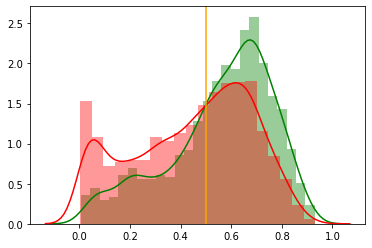

In [4]:
model_parts.evaluate_model(X_test.text, y_test, clf)

## Understanding False Positives

So our model seems to be quite okay at find the real trump's messages. Unfortunately there are still a lot of false postives, which we'll try and understand better here.

For now we'll focus on false positives with a threshold of `0.5`

In [5]:
y_probs = clf.predict_proba(X_test.text)[:,1]
fp_ind = (y_probs > 0.5) & ~y_test

for msg in X_test[fp_ind]["text"][:10].values:
    print(msg)

 Thank you Jill Marlon & all for the amazing & personal service. #Chicago'sBestHotel #Trump2016 Thanks.
 Trump for President! Tom Brady as running mate?
 Trump is the man #Trump2016
 I hope the Don throws his hat in the ring for POTUS. He can't be bought! He said this country is going to Hell
Via “DONALD TRUMP: ‘RICH PEOPLE DON’T LIKE ME’–POOR MIDDLE-INCOME PEOPLE ‘LIKE ME BEST’” 
Via "14 Reasons Donald Trump Is Really Running — and Doing Well" 
Today is armed forces day. Thank you to our military service members! I love you all!
 ignoring haters and losers is the best medicine of success build a wall from whatever they throw towards you Sir.
 Look forward to hearing you every Monday on You are exactly what this country needs!!!
 im ready for u to make america great again


Seems to be a data quality issue. These all look like retweets, while we had supposedly filtered those out. Lets look at the messages with `@realDonalTrump`, since it wouldn't really make much sense for trump to reference himself in his tweets.

In [6]:
from eli5.lime import TextExplainer

te = TextExplainer()
te.fit("@enzotorin @realDonaldTrump Trump is the man #Trump2016", clf.predict_proba)
te.explain_prediction()

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,\n       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n       power_t=0.5,\n       random_state=<mtrand.RandomState object at 0x7febc7cb57e0>,\n       shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n       warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='trump2016', weight=2.1113093777225136, std=None, value=1.0), FeatureWeight(feature='man', weight=1.6742020474442514, std=None, value=1.0), FeatureWeight(feature='trump', weight=0.2740678868220363, std=None, value=1.0), FeatureWeight(feature='is the', weight=0.05623343569080074, std=None, value=1.0), FeatureWeight(feature='the man', weight=0.03665380504149125, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=0.01739692901870675, std=None, value=1.0)], neg=[FeatureWeight(feature='man trump2016', weight=-0.9226012932112658, std=None, value=1.0), FeatureWeight(feature='realdonaldtrump', weight=-0.5898990869506704, std=None, value=1.0), FeatureWeight(feature='realdonaldtrump trump', weight=-0.15027300263438087, std=None, value=1.0), FeatureWeight(feature='the', weight=-0.07068298911356408, std=None, value=1.0), FeatureWeight(feature='enzotorin realdonaldtrump', weight=-0.023763317611126496, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.9177863884486224, score=2.412643792218792, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='@enzotorin @realdonaldtrump trump is the man #trump2016', spans=[('realdonaldtrump', [(12, 27)], -0.5898990869506704), ('trump', [(28, 33)], 0.2740678868220363), ('the', [(37, 40)], -0.07068298911356408), ('man', [(41, 44)], 1.6742020474442514), ('trump2016', [(46, 55)], 2.1113093777225136), ('enzotorin realdonaldtrump', [(1, 10), (12, 27)], -0.023763317611126496), ('realdonaldtrump trump', [(12, 27), (28, 33)], -0.15027300263438087), ('is the', [(34, 36), (37, 40)], 0.05623343569080074), ('the man', [(37, 40), (41, 44)], 0.03665380504149125), ('man trump2016', [(41, 44), (46, 55)], -0.9226012932112658)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=2.395246863200085, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=0.01739692901870675, std=None, value=1.0)], neg=[], pos_remaining=0, neg_remaining=0)))], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [7]:
te.fit("@WilyKayote @LenToddWOR I hope the Don throws his hat in the ring for POTUS. He can't be bought! He said this country is going to Hell", clf.predict_proba)
te.explain_prediction()

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,\n       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n       power_t=0.5,\n       random_state=<mtrand.RandomState object at 0x7febc83293a8>,\n       shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n       warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='country', weight=0.5805148665877207, std=None, value=1.0), FeatureWeight(feature='potus', weight=0.40091633077456373, std=None, value=1.0), FeatureWeight(feature='bought', weight=0.22932059490724135, std=None, value=1.0), FeatureWeight(feature='hope', weight=0.20869505523127901, std=None, value=1.0), FeatureWeight(feature='hell', weight=0.18218100928289027, std=None, value=1.0), FeatureWeight(feature='going', weight=0.128832576126697, std=None, value=1.0), FeatureWeight(feature='said', weight=0.12690112728124314, std=None, value=1.0), FeatureWeight(feature='is', weight=0.1207406486213652, std=None, value=1.0), FeatureWeight(feature='he', weight=0.10849943181771371, std=None, value=2.0), FeatureWeight(feature='don', weight=0.09270044291058953, std=None, value=1.0), FeatureWeight(feature='the', weight=0.08340917319662751, std=None, value=2.0), FeatureWeight(feature='can t', weight=0.05721063081447956, std=None, value=1.0), FeatureWeight(feature='this', weight=0.02827542755685062, std=None, value=1.0), FeatureWeight(feature='in', weight=0.025768339627602024, std=None, value=1.0), FeatureWeight(feature='ring', weight=0.02336536982469819, std=None, value=1.0), FeatureWeight(feature='throws', weight=0.016200717531622787, std=None, value=1.0)], neg=[FeatureWeight(feature='is going', weight=-0.09621523555149501, std=None, value=1.0), FeatureWeight(feature='the don', weight=-0.08410004362783557, std=None, value=1.0), FeatureWeight(feature='to hell', weight=-0.07768581670274988, std=None, value=1.0), FeatureWeight(feature='hope the', weight=-0.07167687094359107, std=None, value=1.0), FeatureWeight(feature='be bought', weight=-0.071147996748818, std=None, value=1.0), FeatureWeight(feature='the ring', weight=-0.06153055171683918, std=None, value=1.0), FeatureWeight(feature='going to', weight=-0.05377696527999836, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-0.052853331960883626, std=None, value=1.0), FeatureWeight(feature='country is', weight=-0.04882535902903631, std=None, value=1.0), FeatureWeight(feature='don throws', weight=-0.048556861604937385, std=None, value=1.0), FeatureWeight(feature='this country', weight=-0.04216921226084629, std=None, value=1.0), FeatureWeight(feature='hat', weight=-0.014953614706199648, std=None, value=1.0), FeatureWeight(feature='his hat', weight=-0.008611177384209601, std=None, value=1.0), FeatureWeight(feature='i hope', weight=-0.001624358857265375, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.8428786215245833, score=1.6798043457184788, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document="@wilykayote @lentoddwor i hope the don throws his hat in the ring for potus. he can't be bought! he said this country is going to hell", spans=[('hope', [(26, 30)], 0.20869505523127901), ('the', [(31, 34)], 0.08340917319662751), ('don', [(35, 38)], 0.09270044291058953), ('throws', [(39, 45)], 0.016200717531622787), ('hat', [(50, 53)], -0.014953614706199648), ('in', [(54, 56)], 0.025768339627602024), ('the', [(57, 60)], 0.08340917319662751), ('ring', [(61, 65)], 0.02336536982469819), ('potus', [(70, 75)], 0.40091633077456373), ('he', [(77, 79)], 0.10849943181771371), ('bought', [(89, 95)], 0.22932059490724135), ('he', [(97, 99)], 0.10849943181771371), ('said', [(100, 104)], 0.12690112728124314), ('this', [(105